gmm mit experience driver
customer order
was geordert wird von customer
externe effekte

In [25]:
import importlib
import _1_Preprocessing
importlib.reload(_1_Preprocessing)

<module '_1_Preprocessing' from '/Users/canis/Library/CloudStorage/OneDrive-Persönlich/programme/coding/github/flaschenpost/_1_Preprocessing.py'>

In [27]:
import pandas as pd
from IPython.display import display
import _1_Preprocessing

df_train, df_test = _1_Preprocessing.run_preprocessing()


size before remove outliers:  (15585053, 15)
size after remove outliers:  (14329788, 15)
size after add article total weight:  (14329788, 16)


/Users/canis/Library/CloudStorage/OneDrive-Persönlich/programme/coding/github/flaschenpost/_1_Preprocessing.py:57: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  article_id_dummies = df.groupby('web_order_id')['article_id'].apply(lambda x: pd.Series(


KeyError: 'Column not found: box_id'

In [ ]:
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# Define the list of features to keep
features_to_keep = [
    "article_weight_in_g", "is_business", "is_pre_order", "has_elevator", "floor", 
    "num_previous_orders_customer", "customer_speed"
]

# Add all columns that start with 'crate_count_' and 'article_id_'
features_to_keep += [col for col in df_train.columns if col.startswith('crate_count_')]
features_to_keep += [col for col in df_train.columns if col.startswith('article_id_')]

# Create a new dataframe with only the specified features
df_train_filtered = df_train[features_to_keep]
df_test_filtered = df_test[features_to_keep]

# Update X_train and X_test to use the filtered dataframes
X_train = df_train_filtered
X_test = df_test_filtered

# Apply StandardScaler only on continuous variables
continuous_features = [
    "article_weight_in_g", "floor", "num_previous_orders_customer", "customer_speed"
]

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[continuous_features] = scaler.fit_transform(X_train[continuous_features])
X_test_scaled[continuous_features] = scaler.transform(X_test[continuous_features])

# Assuming 'service_time_in_minutes' is the target variable and the rest are features
X_train = X_train_scaled
y_train = df_train['service_time_in_minutes']
X_test = X_test_scaled
y_test = df_test['service_time_in_minutes']

# Initialize and train the Bayesian Ridge Regression model
model = BayesianRidge()
model.fit(X_train, y_train)

# Predict the values for the test set
y_pred = model.predict(X_test)

# Calculate and print the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Calculate and print the mean absolute error
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')


Mean Squared Error: 26.45291119761192
Mean Absolute Error: 3.507332889302365


In [ ]:
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define a grid of hyperparameters to search over
param_grid = {
    'alpha_1': [1e-6, 1e-5, 1e-4, 1e-3],
    'alpha_2': [1e-6, 1e-5, 1e-4, 1e-3],
    'lambda_1': [1e-6, 1e-5, 1e-4, 1e-3],
    'lambda_2': [1e-6, 1e-5, 1e-4, 1e-3]
}
# Initialize the Bayesian Ridge Regression model
model = BayesianRidge()

# Set up GridSearchCV with 5-fold cross-validation and mean squared error scoring
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5
)

# Fit GridSearchCV on the scaled training data (make sure to scale your features)
grid_search.fit(X_train_scaled, y_train)

# Output the best hyperparameters and the corresponding score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best CV MSE:", -grid_search.best_score_)

# Iterate over the results and print the MSE and MAE for each configuration
for i, params in enumerate(grid_search.cv_results_['params']):
    print(f"Configuration {i+1}: {params}")
    mse = -grid_search.cv_results_['mean_test_score'][i]
    print(f"Mean Squared Error: {mse}")
    # Fit the model with the current parameters
    model.set_params(**params)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Mean Absolute Error: {mae}")

Best Hyperparameters: {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 1e-06}
Best CV MSE: 24.678890603933173


In [ ]:
print("Coefficients:", model.coef_)

Coefficients: [ 2.46797543e+00  4.76779664e-01 -1.87364902e-01  8.79573152e-01
  7.87708358e-01  5.18177544e-01  3.05974727e+00 -4.38447591e-11
 -3.31185967e-11  3.38473663e-14  3.35907987e-13  1.46283706e-14
 -4.90481212e-15  8.98364237e-15  4.18137851e-14  1.27640191e-14
  4.53580068e-14 -8.91005783e-15 -6.49486802e-16 -9.14925681e-29
 -7.25465472e-29  6.85242534e-30  5.88542913e-30  1.67104888e-30
  1.15224646e-29  2.04530778e-30  1.41316135e-32 -1.44997892e-45
  2.59678824e-45 -4.32433116e-46  3.11245603e-45 -8.19485276e-46
  9.77173446e-47  1.96717860e-46  1.65363605e+01  1.59746029e+01
  1.15845051e+00  3.57210343e-01]


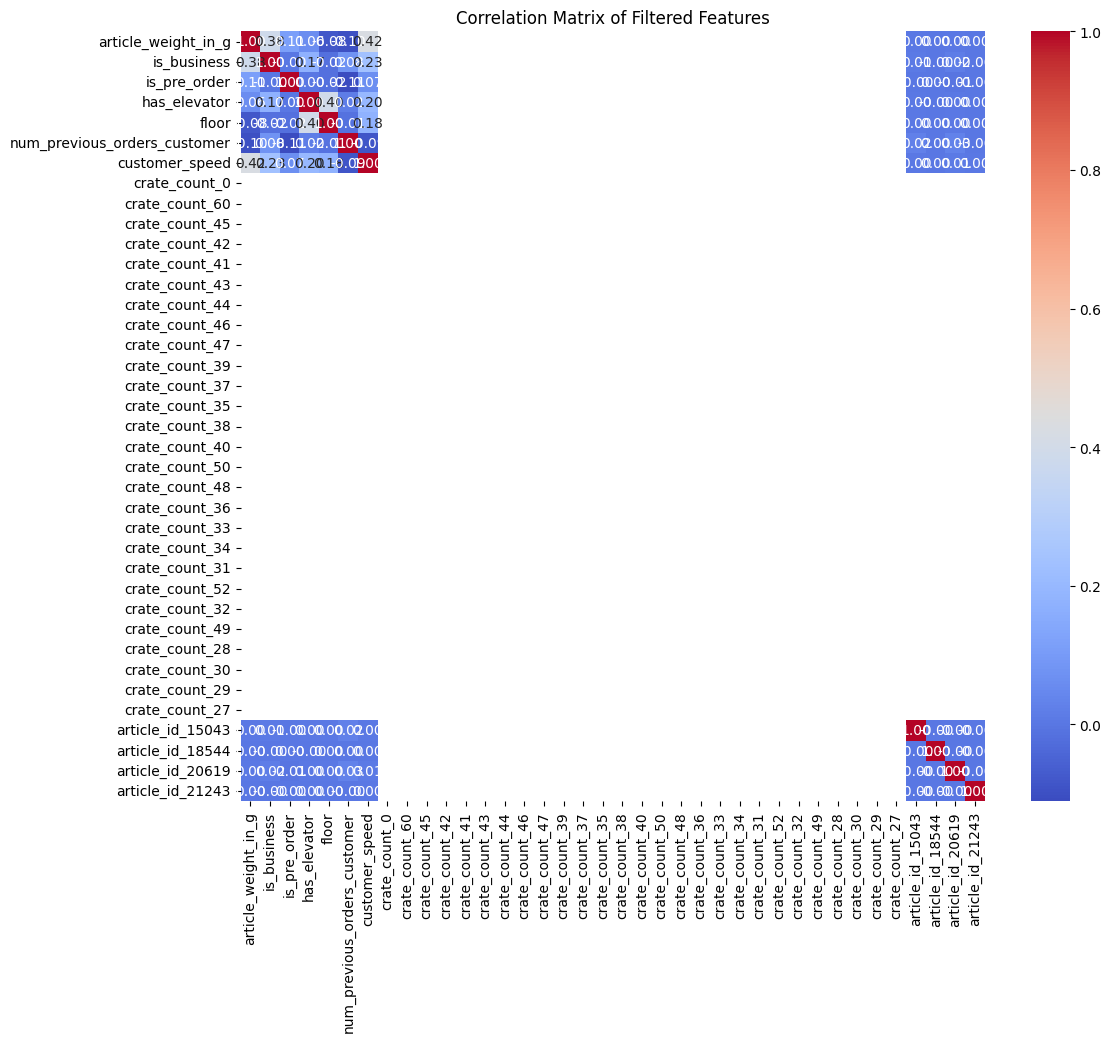

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation matrix on your filtered dataframe
corr_matrix = df_train_filtered.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Filtered Features")
plt.show()

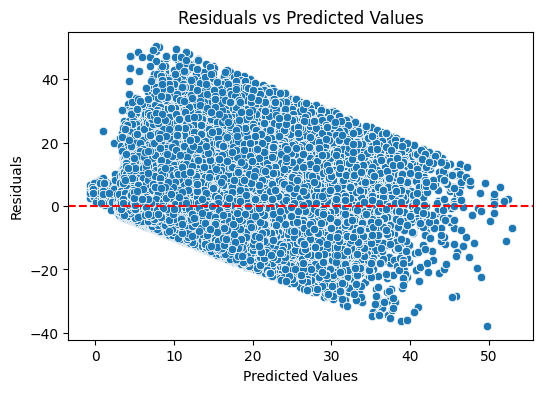

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

residuals = y_test - y_pred
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred, y=residuals)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.axhline(0, color='red', linestyle='--')
plt.show()